In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [40]:
dropbox_path = Path("D:/Dropbox/1_Academics/Research/22-TEGS_modelling/TEGS GenX shared folder/GenX_runs")
location_dir = {
    "newEngland": dropbox_path.joinpath("outputs", "newEngland", "shadow_price_stor2"),
    "texas": dropbox_path.joinpath("outputs", "texas", "shadow_price_stor2"),
}

In [41]:
emissions_levels = [0.01]
temperatures = [2400]
lossrates = [3]
TEGSdischargecaps = [10, 20, 50, 100, 150, 200, 300, 400, 500, 1000, 1500, 2000, 3000, 4000, 5000, 7500, 10000]
TEGSdischarge_chargeratio = [1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 5, 6]
TEGSdischarge_storageratio = [10, 20, 30, 40, 50, 60, 70, 80]

In [42]:
def discharge_per_mw(T):
    discharge_vs_temp = {
        2400: 0.3097 * 1e6,
        2300: 0.3427 * 1e6,
        2100: 0.4926 * 1e6,
        1900: 0.8924 * 1e6
    }
    return discharge_vs_temp[T]

def charge_per_mw(T):
    return 0.0185 * 1e6

def storage_per_mw(T, lossrate):
    storage_vs_temp = {
        2400: 1e3 * np.array([15.827, 12.0636, 10.8529, 10.2619, 9.9158, 9.6914, 9.5363, 9.4243, 9.3411, 9.2779, 9.2292, 9.1915, 9.1622, 9.1395, 9.122]),
        2300: 1e3 * np.array([15.1493, 11.7375, 10.6382, 10.1019, 9.7883, 9.5854, 9.4456, 9.3451, 9.2707, 9.2146, 9.1717, 9.1388, 9.1136, 9.0943, 9.0799]),
        2100: 1e3 * np.array([13.8087, 11.0887, 10.2103, 9.7827, 9.5337, 9.3737, 9.2644, 9.1867, 9.1301, 9.0881, 9.0568, 9.0336, 9.0165, 9.0042, 8.9958]),
        1900: 1e3 * np.array([12.4875, 10.4445, 9.7845, 9.4646, 9.2799, 9.1626, 9.0836, 9.0287, 8.9897, 8.9618, 8.9421, 8.9284, 8.9194, 8.9141, 8.9117]),
    }
    return storage_vs_temp[T][int(lossrate)]

def annuitize(cost, lifetime=30.0, discount_rate=0.05):
    return cost * discount_rate / (1 - (1 + discount_rate) ** (-lifetime))

def tegs_cost(T, lossrate, lifetime=30.0, discount_rate=0.05):
    discharge = annuitize(discharge_per_mw(T), lifetime, discount_rate)
    charge = annuitize(charge_per_mw(T), lifetime, discount_rate)
    storage = annuitize(storage_per_mw(T, lossrate), lifetime, discount_rate)
    return {
        "discharge": discharge,
        "charge": charge,
        "storage": storage,
    }

In [43]:
def make_dirname(emiss_level, temperature, lossrate, TEGSdischargecap, TEGSdischarge_chargeratio, TEGSdischarge_storageratio):
    return f'{float(emiss_level)}_{float(temperature)}_{float(lossrate)}_{float(TEGSdischargecap)}_{float(TEGSdischarge_chargeratio)}_{float(TEGSdischarge_storageratio)}_stor2'

def make_colname(emiss_level, temperature, lossrate, TEGSdischargecap, TEGSdischarge_chargeratio, TEGSdischarge_storageratio):
    return f'{float(emiss_level)}_{float(temperature)}_{float(lossrate)}_{float(TEGSdischarge_chargeratio)}_{float(TEGSdischarge_storageratio)}_stor2'

In [44]:
shadow_prices = {}
tegs_costs = {}
for loc_name, loc_path in location_dir.items():
    prices = pd.DataFrame(index = TEGSdischargecaps)
    shadow_prices[loc_name] = prices
    costs = pd.DataFrame(index = TEGSdischargecaps)
    tegs_costs[loc_name] = costs
    for emiss_level in emissions_levels:
        for tegs_d_c_ratio in TEGSdischarge_chargeratio:
            for tegs_d_s_ratio in TEGSdischarge_storageratio:
                for temperature in temperatures:
                    for lossrate in lossrates:
                        tegs_unit_costs = tegs_cost(temperature, lossrate)
                        for TEGSdischargecap in TEGSdischargecaps:
                            dir_name = make_dirname(emiss_level, temperature, lossrate, TEGSdischargecap, tegs_d_c_ratio, tegs_d_s_ratio)
                            dir_path = loc_path.joinpath(dir_name)
                            file_path = dir_path.joinpath('shadow_price_summ.csv')
                            if file_path.exists():
                                df = pd.read_csv(file_path, index_col=0)
                                colname = make_colname(emiss_level, temperature, lossrate, TEGSdischargecap, tegs_d_c_ratio, tegs_d_s_ratio)
                                prices.loc[TEGSdischargecap, f'{colname}_disch'] = -df.loc["value", " discharge"]
                                prices.loc[TEGSdischargecap, f'{colname}_charg'] = -df.loc["value", " charge"]
                                prices.loc[TEGSdischargecap, f'{colname}_stor'] = -df.loc["value", " storage"]
                                prices.loc[TEGSdischargecap, f'{colname}'] = -df.loc["value", :].sum()

                                costs.loc[TEGSdischargecap, f'{colname}'] = (tegs_unit_costs['discharge'] + tegs_d_c_ratio * tegs_unit_costs['charge'] + tegs_unit_costs['storage'] * tegs_d_s_ratio)
                                

C:\Users\Ruaridh\AppData\Local\Temp\ipykernel_13172\4294471828.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices.loc[TEGSdischargecap, f'{colname}_disch'] = -df.loc["value", " discharge"]
C:\Users\Ruaridh\AppData\Local\Temp\ipykernel_13172\4294471828.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices.loc[TEGSdischargecap, f'{colname}_charg'] = -df.loc["value", " charge"]
C:\Users\Ruaridh\AppData\Local\Temp\ipykernel_13172\4294471828.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

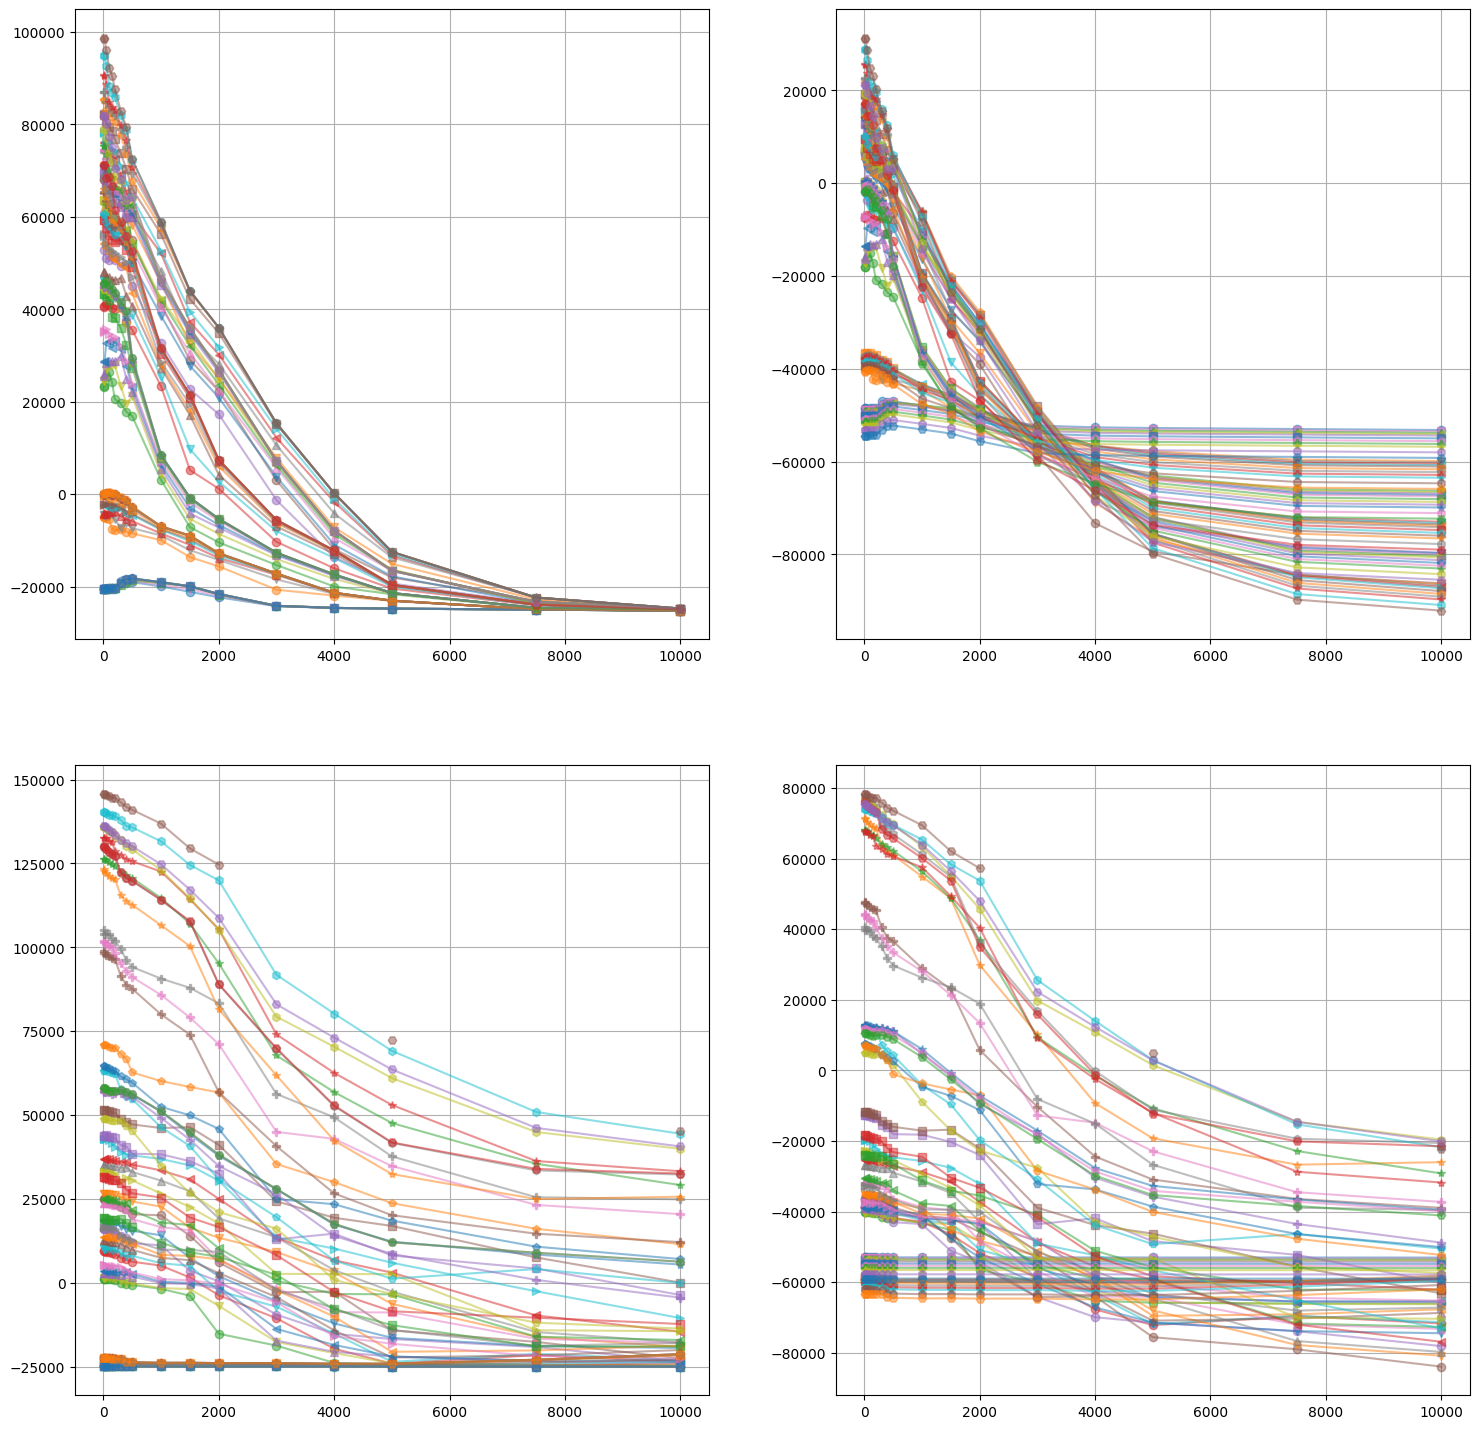

In [52]:
marker_list = ['o','v','^','<','>','s','p','P','*','h','H','X','D','d','|','_']
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

for sc_idx, [loc_name, loc_path] in enumerate(location_dir.items()):
    prices = shadow_prices[loc_name]
    costs = tegs_costs[loc_name]
    for emiss_level in emissions_levels:
        for temperature in temperatures:
            for lossrate in lossrates:

                for idx, tegs_d_c_ratio in enumerate(TEGSdischarge_chargeratio):
                    for tegs_d_s_ratio in TEGSdischarge_storageratio:
                
                            dir_name = make_dirname(emiss_level, temperature, lossrate, TEGSdischargecap, tegs_d_c_ratio, tegs_d_s_ratio)
                            colname = make_colname(emiss_level, temperature, lossrate, TEGSdischargecap, tegs_d_c_ratio, tegs_d_s_ratio)

                            if f'{colname}_disch' in prices.columns:
                                ax[sc_idx,0].plot(prices.index, prices[f'{colname}_disch'], '-', marker=marker_list[idx], alpha=0.5, label=f'D:C={tegs_d_c_ratio} D:S={tegs_d_s_ratio}')

                                ax[sc_idx,1].plot(prices.index, prices[f'{colname}_disch'] - costs[f'{colname}'], '-', marker=marker_list[idx], alpha=0.5, label=f'D:C={tegs_d_c_ratio} D:S={tegs_d_s_ratio}')
                                # ax[idx].set_xscale('log')
                                # ax[idx].set_ylim(0, 125000)
                    # ax.grid()
                    # # ax.legend()
                    # ax.set_xlabel('TEGS discharge capacity (MWhe)')
                    # ax.set_ylabel('TEGS value ($/MWhe)')
                    # ax.set_title(f'Discharge : Charging ratio: 1:{tegs_d_c_ratio}')
                # fig.tight_layout()
                            
for a in ax.flatten():
     a.grid()
                 

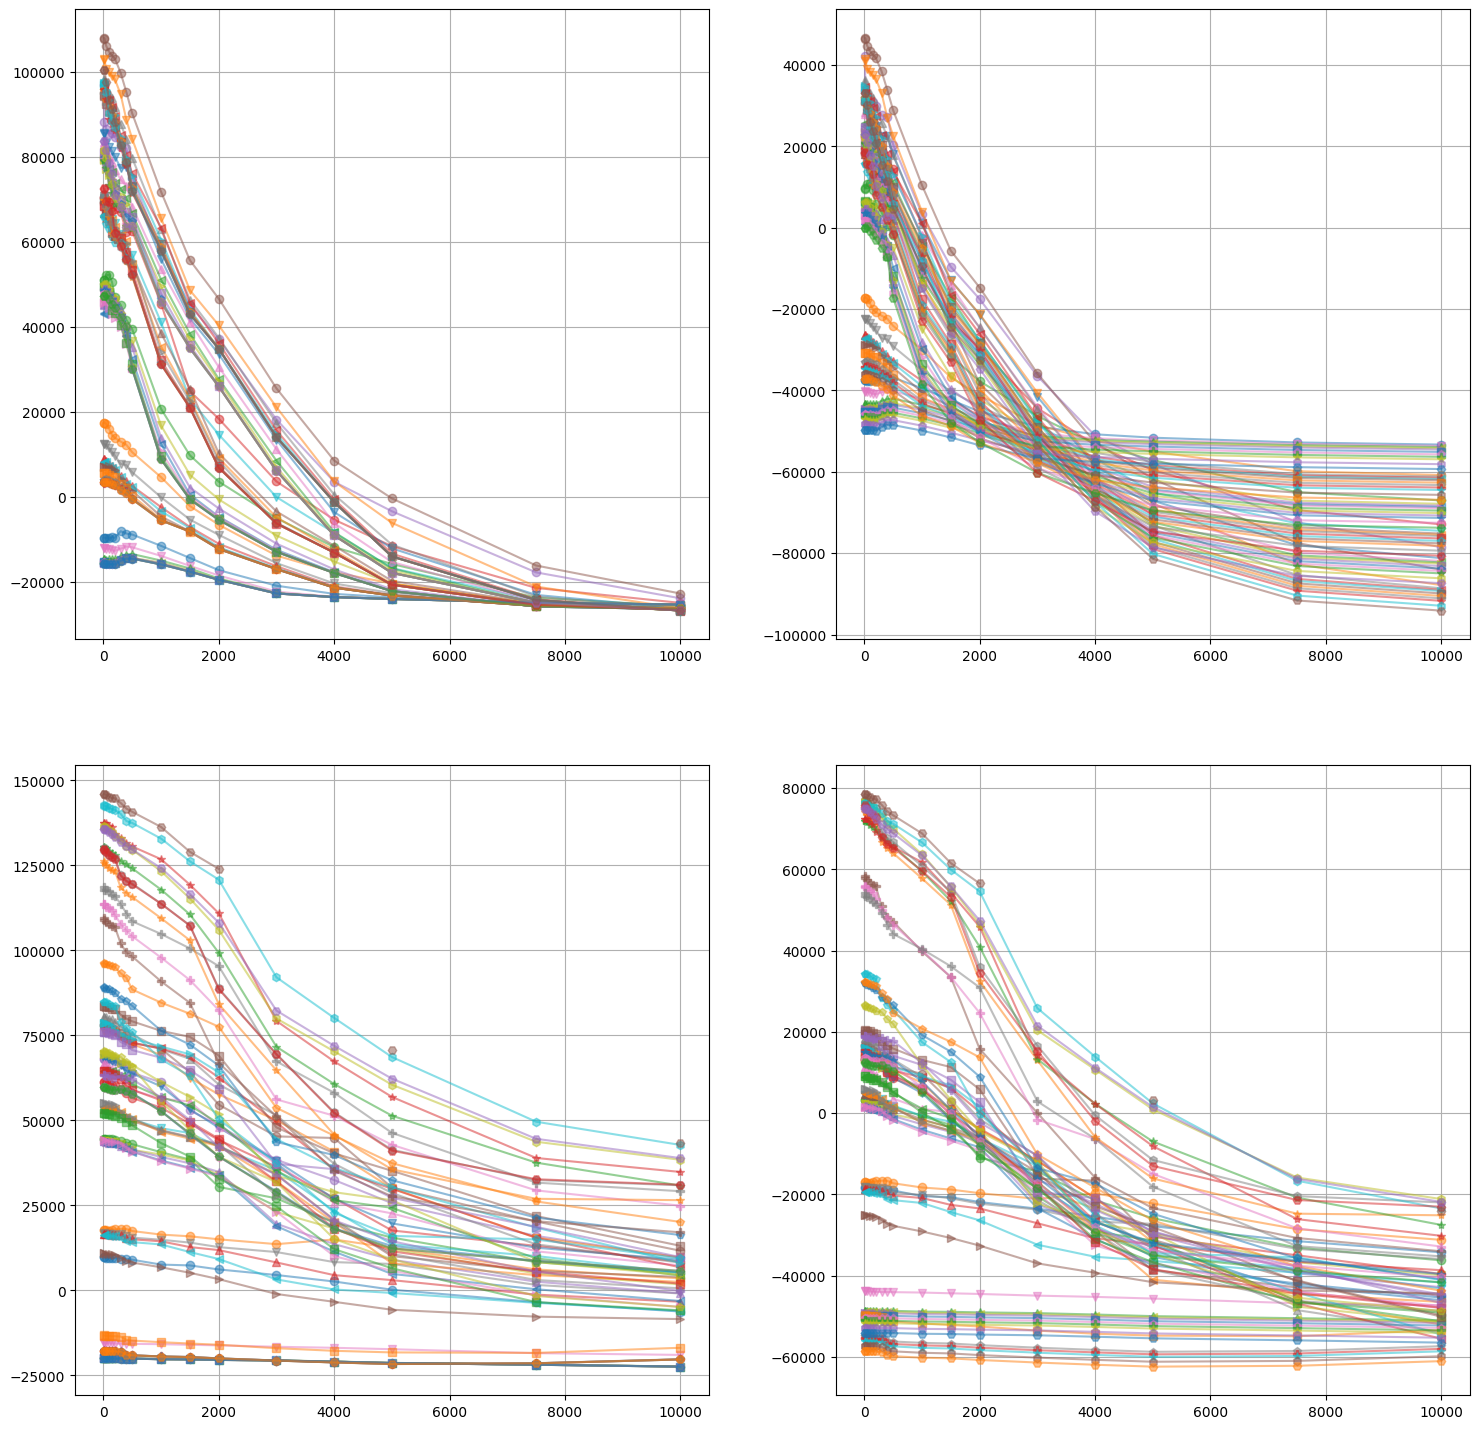

In [51]:
marker_list = ['o','v','^','<','>','s','p','P','*','h','H','X','D','d','|','_']
    
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 18))

for sc_idx, [loc_name, loc_path] in enumerate(location_dir.items()):
    prices = shadow_prices[loc_name]
    costs = tegs_costs[loc_name]
    for emiss_level in emissions_levels:
        for temperature in temperatures:
            for lossrate in lossrates:

                for idx, tegs_d_c_ratio in enumerate(TEGSdischarge_chargeratio):
                    for tegs_d_s_ratio in TEGSdischarge_storageratio:
                
                            dir_name = make_dirname(emiss_level, temperature, lossrate, TEGSdischargecap, tegs_d_c_ratio, tegs_d_s_ratio)
                            colname = make_colname(emiss_level, temperature, lossrate, TEGSdischargecap, tegs_d_c_ratio, tegs_d_s_ratio)

                            if f'{colname}_disch' in prices.columns:
                                ax[sc_idx,0].plot(prices.index, prices[f'{colname}'], '-', marker=marker_list[idx], alpha=0.5, label=f'D:C={tegs_d_c_ratio} D:S={tegs_d_s_ratio}')

                                ax[sc_idx,1].plot(prices.index, prices[f'{colname}'] - costs[f'{colname}'], '-', marker=marker_list[idx], alpha=0.5, label=f'D:C={tegs_d_c_ratio} D:S={tegs_d_s_ratio}')
                                # ax[idx].set_xscale('log')
                                # ax[idx].set_ylim(0, 125000)
                    # ax.grid()
                    # # ax.legend()
                    # ax.set_xlabel('TEGS discharge capacity (MWhe)')
                    # ax.set_ylabel('TEGS value ($/MWhe)')
                    # ax.set_title(f'Discharge : Charging ratio: 1:{tegs_d_c_ratio}')
                # fig.tight_layout()

for a in ax.flatten():
     a.grid()
                            